[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ovsienkobohdan/rpeak-detection/blob/master/metrics_comparison.ipynb)

Metrics: accuracy, speed

In [39]:
import torch
import time
import scipy
import numpy as np
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from RPNet.py_ecg.ecgdetectors import Detectors
from RPNet.utils import score,load_model_CNN
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd

SAVED_MODEL_PATH = "model/model.pt"

In [6]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"

In [ ]:
BATCH_SIZE = 64
time_rpnet = []
samples_rpnet = []
for i in range(28):
    patient_ecg_t = torch.load("data/tensor_ecg.pt")[:64 + 64*i]
    patient_ecg_t = patient_ecg_t.view((patient_ecg_t.shape[0],1,patient_ecg_t.shape[1]))
    patient_ecg_tl = TensorDataset(patient_ecg_t)
    testloader = DataLoader(patient_ecg_tl, batch_size=BATCH_SIZE)
    start = time.time()
    y_pred = load_model_CNN(SAVED_MODEL_PATH,testloader,dev)
    y_pred_1 = [] 
    for batch in range(len(y_pred)):
        for record in range(len(y_pred[batch])):
            y_pred_1.append(y_pred[batch][record].cpu().numpy())
    y_pred_array = np.asarray(y_pred_1) 
    y_pred_array_1 = np.asarray(y_pred_1)
    resampled_dt = []
    for record in range(y_pred_array.shape[0]):
        resampled_dt.append(scipy.signal.resample(y_pred_array_1[record],2000))
    y_pred_array = np.asarray(resampled_dt) 
    peak_locs = []
    for i in range(y_pred_array.shape[0]):
        peak_locs.append(scipy.signal.find_peaks(-y_pred_array[i,:],distance = 45,height = -0.2,prominence = 0.035)[0])
    time_result = int(time.time() - start)
    num_examples = len(patient_ecg_t)
    time_rpnet.append(time_result)
    samples_rpnet.append(num_examples)
    
print(num_examples,":",time_result, "sec")

In [21]:
ecg_signals = np.load("data/ecg.npy", allow_pickle=True)

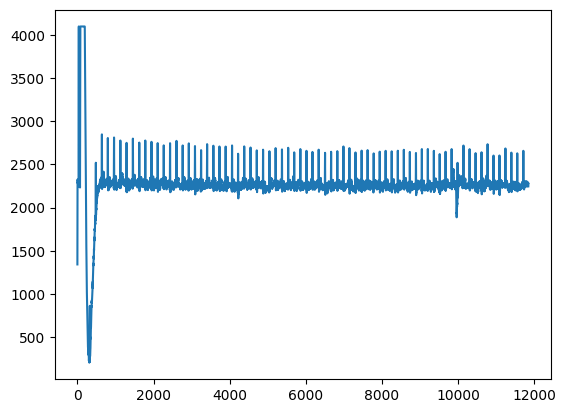

In [23]:
plt.plot(ecg_signals[0])

In [ ]:
fs = 200
detectors = Detectors(fs)
algorithms = [detectors.swt_detector, detectors.hamilton_detector, detectors.christov_detector, detectors.engzee_detector, detectors.pan_tompkins_detector, detectors.two_average_detector]
alg = []
time_algms = []
for alg in tqdm(algorithms):
  time_alg = []
  for ind in tqdm(range(21)):
    start = time.time()
    for i, sig in enumerate(ecg_signals[:17 + 17*ind]):
      r_peaks = alg(sig)
    finish = time.time() - start
    time_alg.append(finish)
  time_algms.append(time_alg)

In [ ]:
num_examples_alg = [len(sum(list(ecg_signals[:17 + 17*i]), [])) / 2000 for i in tqdm(range(21))]
num_examples_alg

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(num_examples_alg, time_algms[0], label = "SWT", linestyle="-") 
plt.plot(num_examples_alg, time_algms[1], label = "Hamilton", linestyle="-") 
plt.plot(num_examples_alg, time_algms[2], label = "Christov", linestyle="-") 
plt.plot(num_examples_alg, time_algms[3], label = "Engzee", linestyle="-") 
plt.plot(num_examples_alg, time_algms[4], label = "Pan Tompkins", linestyle="-") 
plt.plot(num_examples_alg, time_algms[5], label = "Two Average", linestyle="-") 
plt.plot(samples_rpnet, time_rpnet, label = "RPNet", linestyle=":")
if dev == "cpu":
  plt.title("CPU")
else: plt.title("Tesla K80 GPU, 2496 CUDA cores")
plt
plt.xlim([75, 1750])
plt.legend() 
plt.show()

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(num_examples_alg, time_algms[0], label = "SWT", linestyle="-") 
plt.plot(num_examples_alg, time_algms[1], label = "Hamilton", linestyle="-") 
plt.plot(num_examples_alg, time_algms[2], label = "Christov", linestyle="-") 
plt.plot(num_examples_alg, time_algms[3], label = "Engzee", linestyle="-") 
plt.plot(num_examples_alg, time_algms[4], label = "Pan Tompkins", linestyle="-") 
plt.plot(num_examples_alg, time_algms[5], label = "Two Average", linestyle="-") 
plt.plot(samples_rpnet, time_rpnet, label = "RPNet", linestyle=":")
if dev == "cpu":
  plt.title("CPU")
else: plt.title("Tesla K80 GPU, 2496 CUDA cores")
plt
plt.xlim([75, 1750])
plt.xlabel("Number of 10 sec intervals")
plt.ylabel("Seconds (Time of running)")
plt.legend() 
plt.show()

In [35]:
peak = pd.read_csv("data/mawi_peaks.csv")

In [36]:
peak

,Unnamed: 0,File,Peaks
0,0,Z42UD9,"[327, 485, 644, 800, 963, 1129, 1292, 1458, 16..."
1,1,TBDO96,"[610, 610, 917, 1074, 1227, 1374, 1519, 1669, ..."
2,2,XQLA1B,"[331, 493, 651, 812, 970, 1126, 1283, 1443, 16..."
3,3,4T2N8C,"[284, 430, 586, 752, 910, 1071, 1240, 1412, 15..."
4,4,H4773I,"[223, 396, 566, 732, 896, 1059, 1229, 1393, 15..."
...,...,...,...
341,341,L7ASP1,"[201, 365, 365, 533, 702, 870, 1034, 1197, 135..."
342,342,NEJJ5G,"[126, 294, 459, 459, 626, 794, 962, 962, 1130,..."
343,343,8CUHMA,"[108, 272, 444, 615, 784, 944, 1108, 1268, 126..."
344,344,5UEWG7,"[106, 274, 438, 606, 606, 774, 934, 1093, 1246..."


In [37]:
beats = [list(map(int, peak.Peaks[ind][1:-1].split(','))) for ind in range(len(ecg_signals))]

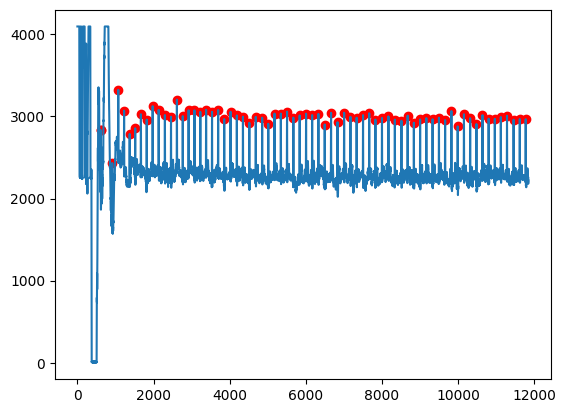

In [38]:
plt.plot(ecg_signals[1])
plt.scatter(beats[1], [ecg_signals[1][i] for i in beats[1]], color="red")

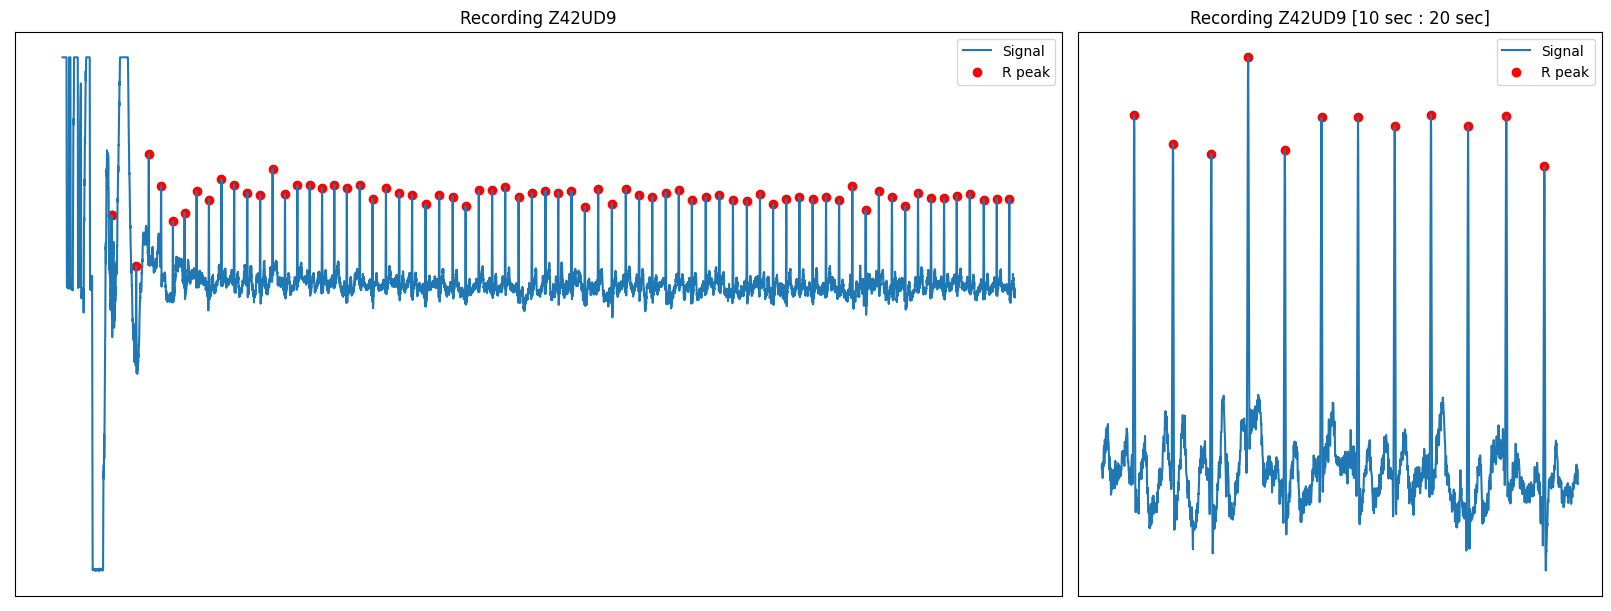

In [40]:
fig = plt.figure(constrained_layout=True, figsize=(16,6))

gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[0, -1:])
ax1.plot(ecg_signals[1], label="Signal")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Recording Z42UD9")
ax1.scatter(beats[1], [ecg_signals[1][i] for i in beats[1]], color="red", label="R peak")
ax1.legend()

ax2.plot(ecg_signals[1][2000: 4000], label="Signal")
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("Recording Z42UD9 [10 sec : 20 sec]")
ax2.scatter([i-2000 for i in beats[1] if i > 2000 and i < 4000], [ecg_signals[1][i] for i in [i for i in beats[1] if i > 2000 and i < 4000]], color="red", label="R peak")
ax2.legend()

In [41]:
beats_ = [np.asarray(i) for i in beats]

In [ ]:
FS = 200
THR = 0.075
detectors = Detectors(FS)
swt = [np.asarray(detectors.swt_detector(i)) for i in ecg_signals]
hamil = [np.asarray(detectors.hamilton_detector(i)) for i in ecg_signals]
christov = [np.asarray(detectors.christov_detector(i)) for i in ecg_signals]
engzee = [np.asarray(detectors.engzee_detector(i)) for i in ecg_signals]
pnt = [np.asarray(detectors.pan_tompkins_detector(i)) for i in ecg_signals]
two_avg = [np.asarray(detectors.two_average_detector(i)) for i in ecg_signals]

print("SWT fuzzy ", score(beats_, swt, FS, THR))
print("Hamil fuzzy ", score(beats_, hamil, FS, THR))
print("Christov fuzzy ", score(beats_, christov, FS, THR))
print("engzee fuzzy ", score(beats_, engzee, FS, THR))
print("pan tompkins fuzzy ", score(beats_, pnt, FS, THR))
print("Two avg fuzzy ", score(beats_, two_avg, FS, THR))